# Solving the Infinite Square Well
## Computing the time evolution of the wavefunction numerically.
Here we explore the wavefunction as it evolves in time, for some *generic* function as the initial state. So instead of doing math to compute the $c_n$ constants, here we do this numerically. In this notebook it is assumed that the solution to the Schrödinger equation is known, or already computed. 

The standard solutions to the infinite square well, on the domain $0<x<a$, is given by:
$$
\left<x|\psi_n\right>=\psi_n(x) = \sqrt{\frac{2}{a}} \sin\left(\frac{n\pi x}{a}\right) \\
E_n = \frac{n^2 \pi^2 \hbar^2}{2ma^2}
$$

For this problem, we have some initial wave function given by $\Psi(x,t=0)$.
We now want to find the $c_n$ coefficients, which is done with
$$
c_n = \left<\psi_n\right.\left|\Psi(t=0)\right> \\
= \int_0^a \psi_n(x) \Psi(x,t=0) dx
$$
We will need to do this integral numerically, so that it will work for any function $\Psi(x,0)$.

How do we integrate? As usual with these types of problems, there are multiple ways to do this, and the difference will be determined by what is available for input, the speed of execution and the accuracy of the result we obtain.

### Method 1 - Summing
We can simply do the integral as a sum. For the situation where the $\psi_n(x)$ functions are not known mathematically but only numerically, this would be the only choice. That is what you would do if you solved the Schrödinger equation numerically as well. If we choose a sufficiently large number of values $N$ in our integration range, then this would be quite accurate, however, it will not be optimally efficient if we know the functional form of $\psi_n(x)$.

For this method, what we do is:
$$
c_n = \int_0^a \psi_n(x) \Psi(x,t=0) dx \rightarrow \frac{a}{N}\sum_{n=0}^N \psi_n(x_i)\Psi(x_i,0),\ \ x_i = \frac{n a}{N}
$$
Note that you need to do this sum about $N$ times to get all the $c_n$ you need to get the same accuracy as this integral. This means the algorithms takes $N\times N$ computations, which adds up, so it can be slow.

### Method 2 - SciPy
There is a nice method in the Scipy package that does integration for us, and it takes care of all the little headaches like how large a value we should choose for $N$. We can tell the package how accurate we want the result to, so we can tell it to be either faster or more accurate. The method is part of scipy.integrate and is called quad(fun,low,hi,<options>), where *fun* is the function (a Python method), and *low* and *hi* are the integration limits, which can be np.inf for $\infty$.
Among option, we can set 'limit=N' to up to N itterations, 'epsabs=1.E-4' to get an accuracy of $10^{-4}$. [See the full documentation](https://docs.scipy.org/doc/scipy-0.18.1/reference/generated/scipy.integrate.quad.html).

### Method 3 - Fast Fourier Transform
Since the $\psi(x)$ functions are *sine* functions, we can do the computations as a Fast Fourier Transform. In some sense, this is close to method 1, except that we can now make use of much faster computational algorithms, which will reduce the number of computations to $N \ln(N)$ times, which is a *lot* better. The disadvantage of doing this is that it will only work for our infinite square well, and due to the FFT (Fast Fourier Transform) it somewhat obscures what is going on.

I will develop Method 2 here as our choice for our problem, primarily because it is more universal and more clear than method 3. 

So, getting started with the programming, we first import the needed packages:

In [1]:
%matplotlib inline
import numpy as np
import scipy.integrate as spi
import matplotlib.pyplot as plt

We now want to program our initial wavefunction. Here I take the same wave function as we used before (Homework3_plucked_string), so we can compare the results with the output from that notebook.

We have
$$
\Psi(x,0) = \left\{ \begin{matrix} A' x, \qquad &\mathrm{if\ } 0\le x \le a/2, \\ A'(a-x), \qquad &\mathrm{if\ } a/2\le x \le a \end{matrix}\right.
$$

A minor issue with this function, from a program point of view, is that it has a discontinuity at $x=a/2$. It also has a discontinuity at $x=0$ and $x=a$, but we can just agree to never call it with values outside of the range $[0,a]$. The "normal" way to implement this function would be:

In [2]:
def f_slow(x,a):
    norm = np.sqrt(12./(a*a*a))
    if x < a/2:
        return(norm*x)
    else:
        return(norm*(a-x))

We run a quick test to make sure the output makes sense. Note that if you write "12" instead of "12." then you only get zero as output. We need to make sure we use floating point!

In [3]:
print f_slow(0,10.),f_slow(3,10),f_slow(5,10),f_slow(7,10),f_slow(10,10)

0.0 0.328633534503 0.547722557505 0.328633534503 0.0


The problem with our function is that we cannot call it with an array, so:

  `print f_slow([0,3.,5.,7.,10.],10.)`

will fail. The way around this is to use  [np.piecewise](https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.piecewise.html), which can take care of the conditions in a piecewise function. We then get:

In [4]:
def f(x,a):
    norm = np.sqrt(12./(a*a*a))
    return(np.piecewise(x,[x<a/2.,x>=a/2.],
                        [lambda x: norm*x ,
                         lambda x: norm*(a-x)]))

In [5]:
print f(np.array([0,3,5,7,10],dtype=float),10)

[ 0.          0.32863353  0.54772256  0.32863353  0.        ]


We next define our $\psi_n(x)$ function, which is fairly straight forward:

In [6]:
def psi_n(x,n,a):
    return(np.sqrt(2./a)*np.sin(n*x*np.pi/a))

In [7]:
# Here is an alternate initial function, which gives nice oscillatory behavious, see HW2
# def f(x,a):
#    norm = 1./np.sqrt(2)
#    return(norm*(psi_n(x,1,a)+psi_n(x,2,a)))

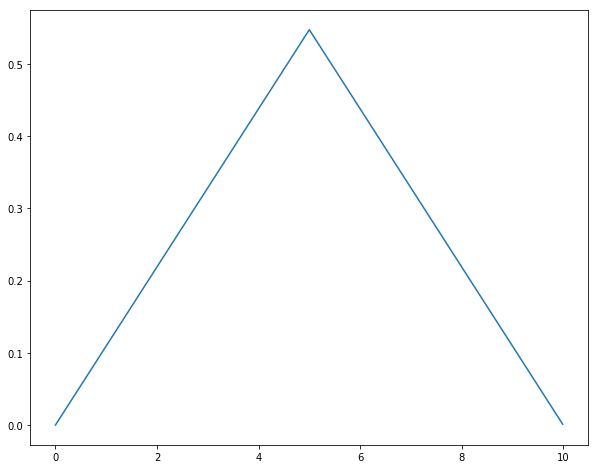

In [8]:
fig0=plt.figure(figsize=(10,8))
x_r = np.arange(0,10,0.01)
p0=plt.plot(x_r,f(x_r,10))

We can now compute the $c_n$. First we write a basic function `ccc` that multiplies $\Psi(x,t=0)$ with $\psi_n(x)$ for a specific $n$. We then find the coefficient $c_n$ by integrating `ccc` from 0 to $a$.

In [9]:
def int_fun(x,n,a):
    return(f(x,a)*psi_n(x,n,a))

def c(n,a):
    if n==0 or n%2==0:       # If we know the even n are zero add: "or n%2==0"
        return(0)
    return( spi.quad(int_fun,0,a,args=(n,a),limit=100)[0])

Because it is quite slow to do this integration each time, we can pre-compute the values of $c_n$ and put them in a big list. Since $c_{39}$ is already quite small, we can stop there. 

In [24]:
Nmax=40 # cutoff for the c_n series. Higher = slower, more accurate
a_l = 10. # Width of the well
a_step = 10./100. # How big is the step in x, smaller is more accurate.
nl = np.array(range(Nmax))
cx = np.array([c(n,a_l) for n in nl])
print cx[0],cx[1],cx[2],cx[3],cx[4]
print np.sum(cx*cx),cx[Nmax-1]

0.0 0.992740800234 0.0 -0.110304533359 0.0
0.999997436706 -0.000652689546504


At this point, we can just follow along with what we did before, when we had a simple function for the $c_n$. Note that the plots below are identical to what we found before, so it seems this method works.

We write a function that encodes the time dependent wave-function itself. To do this, we first need a function that returns the energy of the system. We simplify things a little by choosing $m=1$ and $\hbar=1$, which essentially is a choice of units. We pass the value for the width of the well, $a$.

Our first version of this function is fairly straight forward, but since we end up calling this function a lot when making plots, we find that in this case the slowness of it becomes noticable. It takes about 2 minutes to make the plots. A faster version of the function is written right below, which does the same thing but again uses the Numpy speedups. This version makes the plots in about 2 seconds on my system.

In [25]:
def E(n,a):
    return(n*n*np.pi*np.pi/(2.*a*a)) # We set m/hbar =1

def psi_f(x,t,a):
    norm =np.sqrt(2/a)
    out = 0
    n_r = np.array(range(Nmax))
    out = cx*norm*np.sin(x*n_r*np.pi/a)*np.exp(-1.j*E(n_r,a)*t)
    s = np.sum(out)
    return(s)

Now below we make plots of the real part of the wave function, so see how it evolves. Note that since this is only the *real* part, we do not expect these plots to remain normalized. Below this we do the same for the imaginary part of the wave function, and finally the absolute of the wave function. In that last set of plots, the norm of the curves *does* stay equal to one.

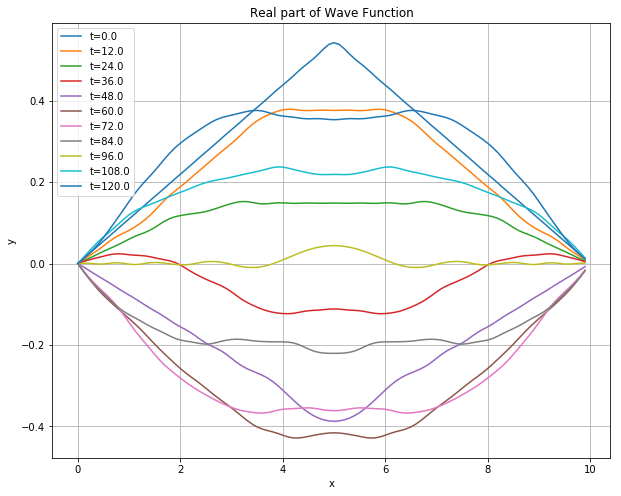

In [27]:
fig1 = plt.figure(figsize=(10,8))
x_r = np.arange(0,a_l,.1)
plts=[]
for t in np.arange(0.,128.,12.):
    y_p = [np.real(psi_f(x,t,a_l)) for x in x_r]
    pp=plt.plot(x_r,y_p,label="t={}".format(t))
    plt.legend() 
    plt.title("Real part of Wave Function")
    plt.xlabel("x")
    plt.ylabel("y")
    plt.grid(True,which='both')
    plts.append(pp)
#fig.show()

Nice, but, I would like this to be, well, cooler. This is a bit old fashioned, so let's do this as an animation. 

Turns out that this is not difficult to do in Python, and even in a Python notebook, but it just doesn't work with a PDF. We're not yet there to have our printed pages be animated. So the following only works if you load the notebook on your own computer and then execute the cells.

One detail to think about is: How long does this need to run? In other words, when will the video repeat? If we look at the solution to the full Schrödinger equation, then we see that each $n$ term rotates in complex space with $-E_n t/\hbar$, and since all energies above the ground state are whole integers (squared) larger, we get the movie to repeat itself when 
$$
\frac{E_1 t}{\hbar} = 2\pi \Rightarrow t = \frac{2\pi\hbar}{E_1} = 2\pi\hbar  \frac{2ma^2}{\pi^2\hbar^2} = \frac{4ma^2}{\pi\hbar}
$$
For the given width then, we get:

In [31]:
print "a = {:4.1f} then T = {:8.3f}".format(a_l,4*a_l**2/np.pi)

a = 10.0 then T =  127.324


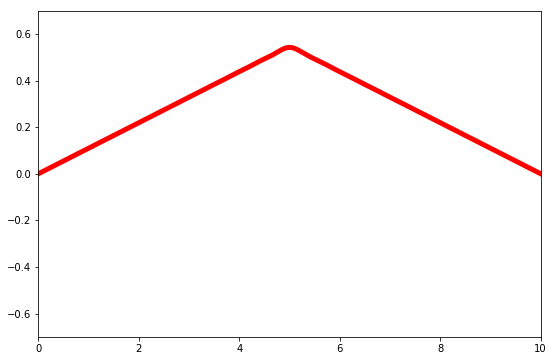

In [32]:
import matplotlib.animation as animation
# from   matplotlib import rc
from IPython.display import HTML
T = 4*a_l**2/np.pi
fig = plt.figure(figsize=(9,6))              # Setup the figure
ax = plt.axes(xlim=[0,a_l],ylim=[-0.7,0.7])  # Setup the axes.
# Next we define the line to plot, line width = 5, color="red". 
line, = ax.plot(x_r,np.zeros(len(x_r)),lw=5,color="red")
def animate(t):                              # Update the line for t.
    y_p = [np.real(psi_f(x,t,a_l)) for x in x_r] # Compute the data.
    line.set_data(x_r,y_p)                   # Set the data in the line
    line.set_color((t/T,1.-t/T,0))     # Animate the color with t.
    return (line,)                             # return the line as tuple (line,)

def init():
    line.set_data([],[])                     # Just a blank line.
    return (line,)

# Next we call the animation function. This does all the work, but 
# in a Jupyter notebook, it won't be visibly moving.
# We animate 100 frames from 0 to T and then repeat.
ani = animation.FuncAnimation(fig, animate, np.linspace(0.,T,100), init_func=init,
                              interval=100, blit=True)
HTML(ani.to_html5_video()) # This says: embed the animation as a video.

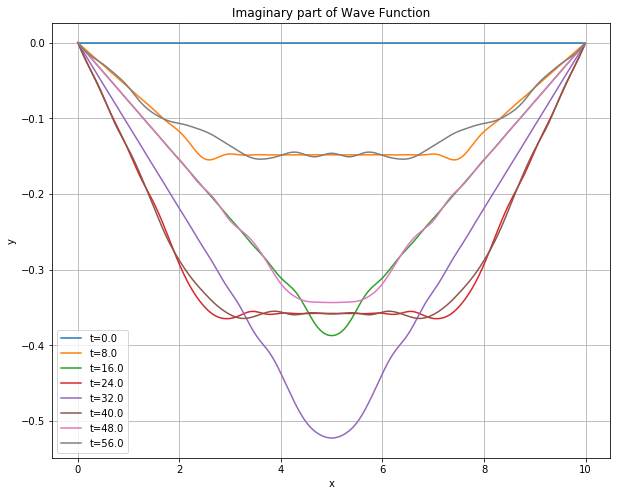

In [33]:
plt.figure(figsize=(10,8))
x_r = np.arange(0,10,0.01)
for t in np.arange(0.,64.,8.):
    y_p = [np.imag(psi_f(x,t,a_l)) for x in x_r]
    plt.plot(x_r,y_p,label="t={}".format(t))
    plt.legend() 
    plt.title("Imaginary part of Wave Function")
    plt.xlabel("x")
    plt.ylabel("y")
    plt.grid(True,which='both')
plt.show()

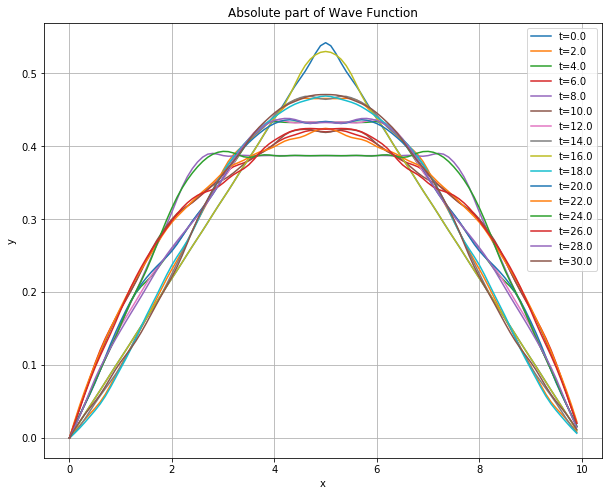

In [34]:
plt.figure(figsize=(10,8))
x_r = np.arange(0,10,0.1)
for t in np.arange(0.,32.,2.):
    y_p = [np.abs(psi_f(x,t,a_l)) for x in x_r]
    plt.plot(x_r,y_p,label="t={}".format(t))
    plt.legend() 
    plt.title("Absolute part of Wave Function")
    plt.xlabel("x")
    plt.ylabel("y")
    plt.grid(True,which='both')
plt.show()